In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util
from bmi_dynamics_code import analyze_lqr

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
#Load a base file for simulation parameters: 
ext_list =['.png', '.eps']

plot_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


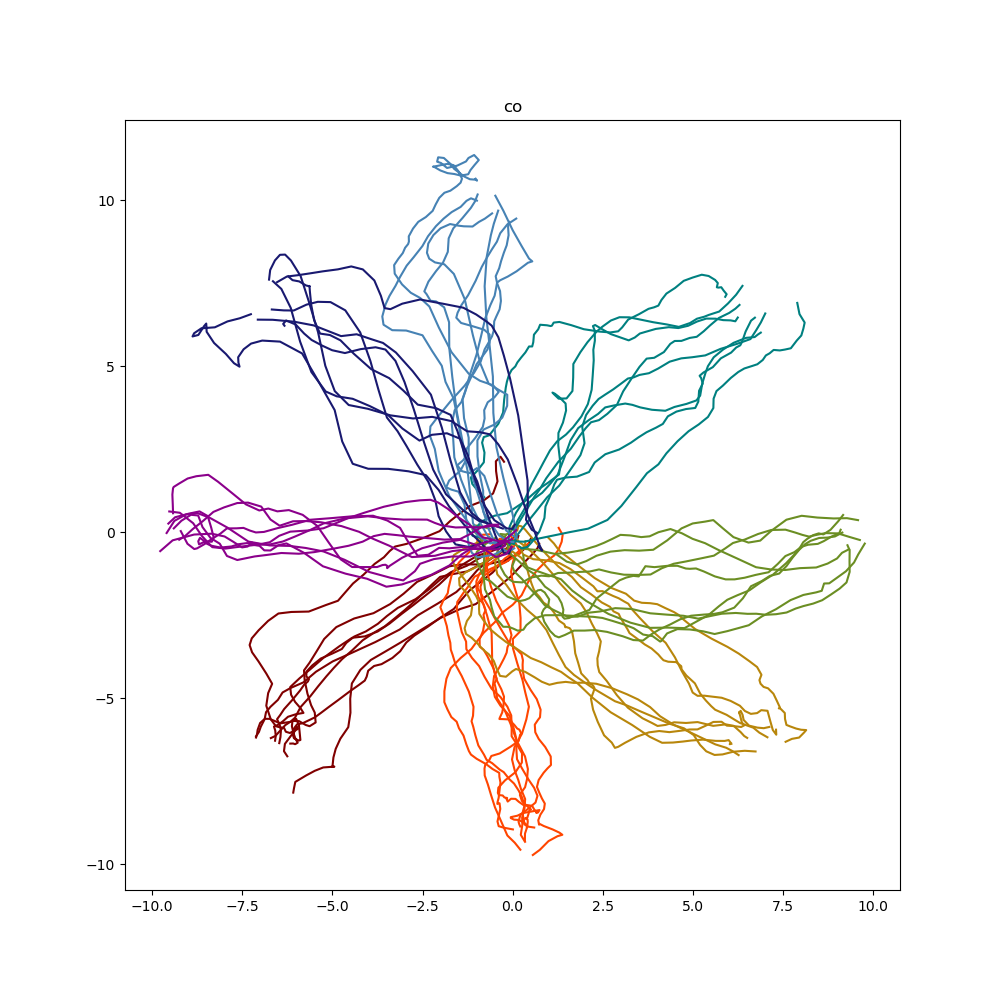

<IPython.core.display.Javascript object>


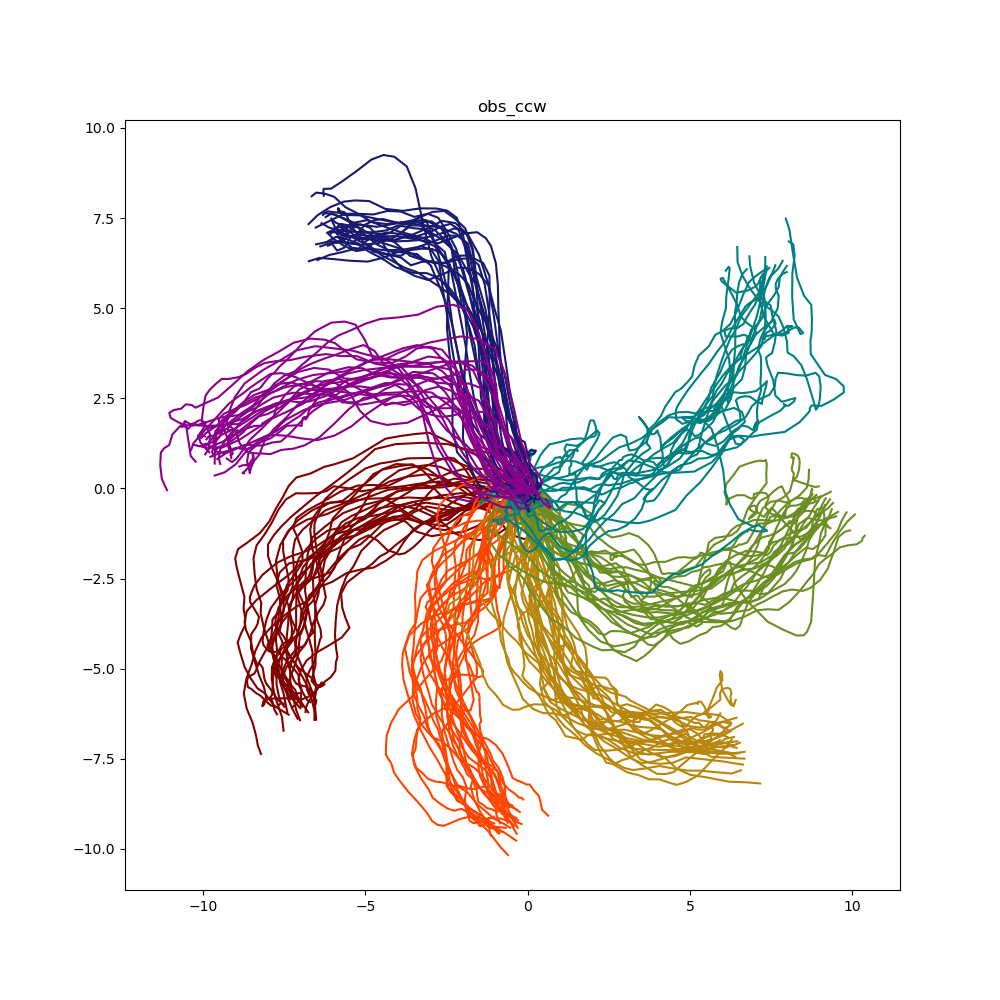

<IPython.core.display.Javascript object>


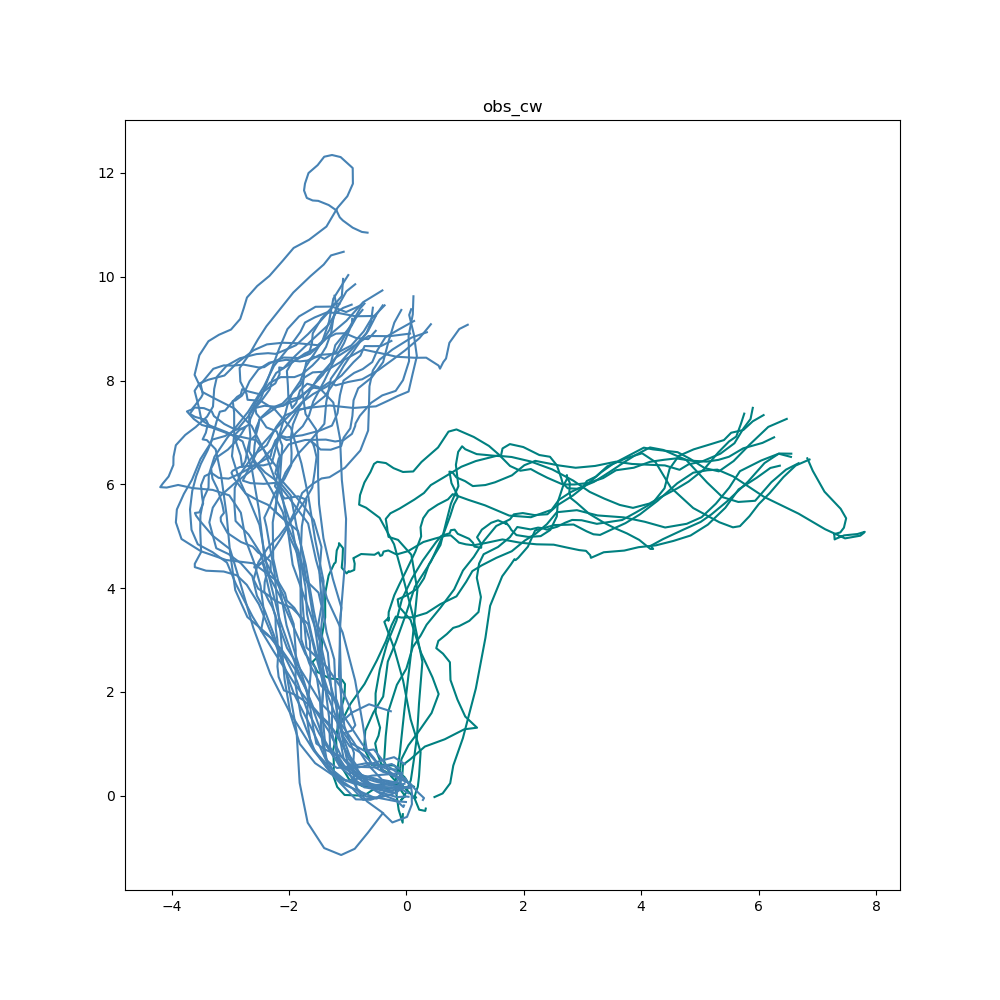

In [5]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

In [6]:
a_list = ['grom', 'jeev']
a2num_days = {'grom':9, 'jeev':4}

In [ ]:
#See 

In [ ]:
a_list

In [ ]:
a2num_days['grom']

In [ ]:
a2num_days['jeev']

In [ ]:
#Pool simulations from 'lqr_sim_20trials.pkl', 'lqr_sim_20trials_decoder_null_dyn.pkl'

In [7]:
#Dynamics models: 
dm_list = ['full', 'decoder_null'] #dynamics, decoder_null dynamics
num_trials = 20 #number of trials simulated with lqr
dm_files = {dm_list[0]:'lqr_sim_'+str(num_trials)+'trials.pkl',\
            dm_list[1]:'lqr_sim_'+str(num_trials)+'trials_decoder_null_dyn.pkl'}

In [8]:
model_list_analyze = \
[('full', 'n_do'), \
 ('decoder_null', 'n_do'), \
 ('full', 'n_o'), \
 ('decoder_null', 'n_o')]

mla = model_list_analyze

model_pairs = []
pair = (mla[0], mla[1])
model_pairs.append(pair)

pair = (mla[0], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[2])
model_pairs.append(pair)

pair = (mla[1], mla[3])
model_pairs.append(pair)


In [10]:
#Load an example lqr sim
a = 'grom'
d = 0

save_home = r'D:\DATA\bmi_co_obs_backup'
load_dir = os.path.join(save_home, a, str(d))
sim_dm_paths = {}
for dm in dm_list:
    sim_dm_paths[dm] = os.path.join(load_dir, dm_files[dm])
lqr_dm, df_pool = analyze_lqr.pool_lqr_sim_across_dm(dm_list, sim_dm_paths)  


In [11]:
#Information for analysis: 
save_home = r'D:\DATA\bmi_co_obs_backup'

#analyze neural diff: 
p_sig_match = 0.05
shuffle_bool = True
num_shuffle = 3 #1000
min_obs = 15

#Save information
save_file = \
'analysis_lqr_sim_full_vs_decoder_null_'+str(num_trials)+'trials_'+ str(num_shuffle) + 'shuffles' +'.pkl'
print(save_file)

analysis_lqr_sim_full_vs_decoder_null_20trials_3shuffles.pkl


In [12]:
#Run analysis:
debug_bool = True
for a in a_list: # [a_list[0]]:
    for d in range(a2num_days[a]): #[0]: 
        t_iter_start = timeit.default_timer()
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
        
        if not debug_bool:
            #lqr sim paths for dynamics models (dm):
            sim_dm_paths = {}
            for dm in dm_list:
                sim_dm_paths[dm] = os.path.join(load_dir, dm_files[dm])
            lqr_dm, df_pool = analyze_lqr.pool_lqr_sim_across_dm(dm_list, sim_dm_path)

        #Load some params, must be the same across dynamics models: 
        target_list = lqr_dm[dm_list[0]]['target_list'] 
        task_rot_list = lqr_dm[dm_list[0]]['task_rot_list'] 
        num_neurons = lqr_dm[dm_list[0]]['num_neurons']
        #Decoder:
        Kn = lqr_dm[dm_list[0]]['Kn']
        
        #labels for movements, commands, neurons:
        move_list, c_list, n_list = \
        analyze_lqr.def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)
        
        
        if debug_bool:
            move_list = [move_list[0]]
            c_list = c_list[0:2] #[c_list[0]]
        
        #analyze u norm:
        r_u = \
        analyze_lqr.analyze_u_norm(lqr_dm, model_list_analyze, model_pairs, target_list, task_rot_list)
        
        #Analyze the difference in neural activity for (command,movement) from the movement-pooled neural activity
        model_cm =  \
        analyze_lqr.main_compute_neural_command_diff(df_pool['df_lqr_n'], Kn, model_list_analyze, move_list, c_list, n_list, p_sig_match, shuffle_bool, num_shuffle)
        model_diff = analyze_lqr.collect_neural_command_diff(model_cm, Kn, model_list_analyze, c_list, move_list, min_obs, shuffle_bool)
        
        r_n = analyze_lqr.analyze_n_diff(model_diff, model_list_analyze, model_pairs)
        
        #Save results: 
        r = {}
        r['num_targets'] = num_targets
        r['task_rot_list'] = task_rot_list
        r['num_mag_bins_analyze'] = num_mag_bins_analyze
        r['num_angle_bins'] = num_angle_bins
        r['num_neurons'] = num_neurons
        r['m_list'] = move_list
        r['c_list'] = c_list
        r['n_list'] = n_list
        r['p_sig_match'] = p_sig_match
        r['shuffle_bool'] = shuffle_bool
        r['num_shuffle'] = num_shuffle
        r['min_obs'] = min_obs
        r['model_cm'] = model_cm
        r['model_diff'] = model_diff
        r['norm_u_df_n'] = df_pool['norm_u_df_n']
        r['r_u'] = r_u
        r['r_n'] = r_n
        
        save_dir = os.path.join(save_home, a, str(d))
        save_path = os.path.join(save_dir, save_file)
        print(save_path)
        with open(save_path, 'wb') as f: 
            data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)    
            
        t_iter_elapsed = timeit.default_timer()-t_iter_start
        print('time iteration: ' + str(t_iter_elapsed))
        print('DONE!')        
        
        

('grom', 0)
(('full', 'n_do'), (0, 0), (0, 0))
(('full', 'n_do'), (0, 1), (0, 0))
(('decoder_null', 'n_do'), (0, 0), (0, 0))
(('decoder_null', 'n_do'), (0, 1), (0, 0))
(('full', 'n_o'), (0, 0), (0, 0))
(('full', 'n_o'), (0, 1), (0, 0))
(('decoder_null', 'n_o'), (0, 0), (0, 0))
(('decoder_null', 'n_o'), (0, 1), (0, 0))
0.1843564
(('full', 'n_do'), (0, 0), (0, 0))
0.95
501
0.9
475
0.85
448
0.8
422
0.75
396
0.7
369
0.65
343
0.6
316
0.55
290
0.5
matched!
(('full', 'n_do'), (0, 1), (0, 0))
0.95
983
0.9
matched!
(('decoder_null', 'n_do'), (0, 0), (0, 0))
0.95
423
0.9
401
0.85
379
0.8
356
0.75
334
0.7
312
0.65
289
0.6
267
0.55
245
0.5
223
0.45
matched!
(('decoder_null', 'n_do'), (0, 1), (0, 0))
0.95
matched!
(('full', 'n_o'), (0, 0), (0, 0))
0.95
518
0.9
491
0.85
464
0.8
436
0.75
409
0.7
382
0.65
354
0.6
327
0.55
300
0.5
273
0.45
245
0.4
218
0.35
matched!
(('full', 'n_o'), (0, 1), (0, 0))
0.95
matched!
(('decoder_null', 'n_o'), (0, 0), (0, 0))
0.95
417
0.9
395
0.85
373
0.8
351
0.75
329
0.7
30

0.95
501
0.9
475
0.85
448
0.8
422
0.75
396
0.7
369
0.65
343
0.6
316
0.55
290
0.5
matched!
(('full', 'n_do'), (0, 1), (0, 0))
0.95
983
0.9
matched!
(('decoder_null', 'n_do'), (0, 0), (0, 0))
0.95
423
0.9
401
0.85
379
0.8
356
0.75
334
0.7
312
0.65
289
0.6
267
0.55
245
0.5
223
0.45
matched!
(('decoder_null', 'n_do'), (0, 1), (0, 0))
0.95
matched!
(('full', 'n_o'), (0, 0), (0, 0))
0.95
518
0.9
491
0.85
464
0.8
436
0.75
409
0.7
382
0.65
354
0.6
327
0.55
300
0.5
273
0.45
245
0.4
218
0.35
matched!
(('full', 'n_o'), (0, 1), (0, 0))
0.95
matched!
(('decoder_null', 'n_o'), (0, 0), (0, 0))
0.95
417
0.9
395
0.85
373
0.8
351
0.75
329
0.7
307
0.65
285
0.6
263
0.55
241
0.5
219
0.45
matched!
(('decoder_null', 'n_o'), (0, 1), (0, 0))
0.95
matched!
2.268488
0.0052074
(('full', 'n_do'), (0, 0), (0, 0))
(('full', 'n_do'), (0, 1), (0, 0))
(('decoder_null', 'n_do'), (0, 0), (0, 0))
(('decoder_null', 'n_do'), (0, 1), (0, 0))
(('full', 'n_o'), (0, 0), (0, 0))
(('full', 'n_o'), (0, 1), (0, 0))
(('decoder_null'

0.85
464
0.8
436
0.75
409
0.7
382
0.65
354
0.6
327
0.55
300
0.5
273
0.45
245
0.4
218
0.35
matched!
(('full', 'n_o'), (0, 1), (0, 0))
0.95
matched!
(('decoder_null', 'n_o'), (0, 0), (0, 0))
0.95
417
0.9
395
0.85
373
0.8
351
0.75
329
0.7
307
0.65
285
0.6
263
0.55
241
0.5
219
0.45
matched!
(('decoder_null', 'n_o'), (0, 1), (0, 0))
0.95
matched!
2.4019034
0.005041
(('full', 'n_do'), (0, 0), (0, 0))
(('full', 'n_do'), (0, 1), (0, 0))
(('decoder_null', 'n_do'), (0, 0), (0, 0))
(('decoder_null', 'n_do'), (0, 1), (0, 0))
(('full', 'n_o'), (0, 0), (0, 0))
(('full', 'n_o'), (0, 1), (0, 0))
(('decoder_null', 'n_o'), (0, 0), (0, 0))
(('decoder_null', 'n_o'), (0, 1), (0, 0))
0.2130159
D:\DATA\bmi_co_obs_backup\jeev\1\analysis_lqr_sim_full_vs_decoder_null_20trials_3shuffles.pkl
time iteration: 3.054633
DONE!
('jeev', 2)
(('full', 'n_do'), (0, 0), (0, 0))
(('full', 'n_do'), (0, 1), (0, 0))
(('decoder_null', 'n_do'), (0, 0), (0, 0))
(('decoder_null', 'n_do'), (0, 1), (0, 0))
(('full', 'n_o'), (0, 0), 

In [13]:
for m in model_list_analyze:
    print(m)
    print(r_u[m])
    print('')

('full', 'n_do')
[4.868991156645722, 8.986620428798338, 9.083868723152502, 4.440141425384462, 8.506722083893722, 9.024485108303669, 3.71917962185537, 8.38728581770155, 9.265630440554565, 3.976267074396053, 8.633406440572676, 9.494308994134085, 4.715385817898001, 8.625764820154, 9.364862513141937, 4.690318742673203, 8.518371530962137, 8.921729981075812, 4.006452089006125, 8.807703204769421, 8.82140528128281, 3.982177738017311, 9.190991865710187, 9.009735182502379]

('decoder_null', 'n_do')
[8.365613363146498, 13.642326791136409, 13.951685524814021, 5.6502575455922015, 12.948483487912998, 12.954880265872713, 5.273430688130147, 12.827120235208142, 12.512368298534962, 6.980854815190298, 12.860964505296394, 12.74500688240965, 7.031755834132065, 12.860065636754126, 13.19350231132594, 6.2562216485470525, 13.184047330944551, 13.380766085161756, 7.698033654655954, 13.91938845939282, 13.548943320215386, 9.081716931748385, 14.255279331911373, 14.096300226751058]

('full', 'n_o')
[6.83701873977739

In [14]:
model_pairs

[(('full', 'n_do'), ('decoder_null', 'n_do')),
 (('full', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

In [15]:
for pair in model_pairs:
    print(pair)
    print(r_u[pair, 'wilcoxon'])
    print('')

(('full', 'n_do'), ('decoder_null', 'n_do'))
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05)

(('full', 'n_do'), ('full', 'n_o'))
WilcoxonResult(statistic=2.0, pvalue=2.3517985308333274e-05)

(('decoder_null', 'n_do'), ('full', 'n_o'))
WilcoxonResult(statistic=102.0, pvalue=0.17024139590961385)

(('decoder_null', 'n_do'), ('decoder_null', 'n_o'))
WilcoxonResult(statistic=123.0, pvalue=0.44045294529422474)



In [ ]:
r_n.keys()

In [16]:
#Load all session's results
load_file = save_file

r_pool = {}
for a in ['grom']:#a_list: 
    for d in [0]: #range(a2num_days[a]):
        print(a,d)
        load_dir = os.path.join(save_home, a, str(d))
#         print(os.path.exists(load_dir))
#         load_file = 'analysis_lqr_sim_20trials.pkl'
        load_path = os.path.join(load_dir, load_file)
        print(load_path)
        with open(load_path, 'rb') as f: 
            r = pickle.load(f)     
        r_pool[(a,d)] = r
#         del r_pool[(a,d)]['model_cm']
        
        

('grom', 0)
D:\DATA\bmi_co_obs_backup\grom\0\analysis_lqr_sim_full_vs_decoder_null_20trials_3shuffles.pkl


### Pool N_diff lme

In [ ]:
#TODO: 
#adapt for the new models

In [18]:
r_pool[a,d]['r_n'].keys()

[(('full', 'n_do'), 'total'),
 (('decoder_null', 'n_do'), 'total'),
 (('full', 'n_o'), 'total'),
 ((('decoder_null', 'n_do'), ('full', 'n_o')), 'model_pair_ks'),
 (('decoder_null', 'n_o'), 'total'),
 ((('decoder_null', 'n_do'), ('decoder_null', 'n_o')), 'model_pair_ks'),
 (('decoder_null', 'n_o'), 'shuffle'),
 (('full', 'n_o'), 'shuffle'),
 ((('full', 'n_do'), ('decoder_null', 'n_do')), 'model_pair_ks'),
 (('full', 'n_do'), 'shuffle'),
 (('decoder_null', 'n_o'), 'model_shuffle_ks'),
 (('decoder_null', 'n_do'), 'model_shuffle_ks'),
 (('decoder_null', 'n_do'), 'shuffle'),
 ((('full', 'n_do'), ('full', 'n_o')), 'model_pair_ks'),
 (('full', 'n_o'), 'model_shuffle_ks'),
 (('full', 'n_do'), 'model_shuffle_ks')]

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [19]:
model_list_analyze

[('full', 'n_do'),
 ('decoder_null', 'n_do'),
 ('full', 'n_o'),
 ('decoder_null', 'n_o')]

In [21]:
model_pairs

[(('full', 'n_do'), ('decoder_null', 'n_do')),
 (('full', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

In [31]:
#Compare neural-activity-distance across pairs in 'model_pairs'
#We will need to loop pairs, and save the results with respect to the pairs
activity_type = 'total'

#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

for a in a_list:
    data[a] = []
    group[a] = []
    model[a] = []
    for pair in model_pairs: #Loop pairs
        for i_m in range(2): #loop the elements of the pair
            m = pair[i_m]
            m_key = (m, activity_type)
            
            for d in range(0): #range(a2num_days[a]):
                data_i = r_pool[a,d]['r_n'][m_key]
                group_i = d*np.ones(len(data_i))
                model_i = i_m*np.ones(len(data_i))
            
        data[a] = np.concatenate(data[a]).reshape((-1,1))
        group[a] = np.concatenate(group[a]).reshape((-1,1))
        model[a] = np.concatenate(model[a]).reshape((-1,1))
    
        pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
        df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
        md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    #     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
        mdf = md.fit()
    #     mdf = md.fit(method=["lbfgs"])
        pv = mdf.pvalues
        print(a)
        print(mdf.summary())
        print(mdf.pvalues)


        #ASSIGN:
        df_dic[a, pair] = df_lme
        df_dic[a, pair, 'mdf'] = mdf
        df_dic[a, pair, 'pv'] = pv

ValueError: need at least one array to concatenate

In [29]:
for i_m, m in pair:
    print(m)

n_do
n_do


In [28]:
pair

(('full', 'n_do'), ('decoder_null', 'n_do'))

In [25]:
model_pairs

[(('full', 'n_do'), ('decoder_null', 'n_do')),
 (('full', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('full', 'n_o')),
 (('decoder_null', 'n_do'), ('decoder_null', 'n_o'))]

In [24]:
r_pool[a,d]['r_n'].keys()

[(('full', 'n_do'), 'total'),
 (('decoder_null', 'n_do'), 'total'),
 (('full', 'n_o'), 'total'),
 ((('decoder_null', 'n_do'), ('full', 'n_o')), 'model_pair_ks'),
 (('decoder_null', 'n_o'), 'total'),
 ((('decoder_null', 'n_do'), ('decoder_null', 'n_o')), 'model_pair_ks'),
 (('decoder_null', 'n_o'), 'shuffle'),
 (('full', 'n_o'), 'shuffle'),
 ((('full', 'n_do'), ('decoder_null', 'n_do')), 'model_pair_ks'),
 (('full', 'n_do'), 'shuffle'),
 (('decoder_null', 'n_o'), 'model_shuffle_ks'),
 (('decoder_null', 'n_do'), 'model_shuffle_ks'),
 (('decoder_null', 'n_do'), 'shuffle'),
 ((('full', 'n_do'), ('full', 'n_o')), 'model_pair_ks'),
 (('full', 'n_o'), 'model_shuffle_ks'),
 (('full', 'n_do'), 'model_shuffle_ks')]

In [ ]:
#OLD CODE: 

In [ ]:
#three lme pool: 
#n_do vs n_o
#n_do (data vs shuffle)
#n_o (data vs shuffle)

model_analyze_list = [] 

model_analyze = [('n_do', 'total'),('n_o', 'total')]
model_analyze_list.append(model_analyze)

model_analyze = [('n_do', 'total'),('n_do', 'shuffle')]
model_analyze_list.append(model_analyze)

model_analyze = [('n_o', 'total'),('n_o', 'shuffle')]
model_analyze_list.append(model_analyze)

In [ ]:
#n_do vs n_o

In [ ]:
test = ['hi']*5
test

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

('decoder_null', 'n_o')

In [ ]:
# n_do VS n_o
#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

model_analyze = [('n_do', 'total'),('n_o', 'total')]

for a in a_list:
    data[a] = []
    group[a] = []
    model[a] = []
    for i_m,m in enumerate(model_analyze):
        for d in range(a2num_days[a]):
            data_i = r_pool[a,d]['r_n'][m]
            group_i = d*np.ones(len(data_i))
            model_i = i_m*np.ones(len(data_i))
            
            data[a].append(data_i)
            group[a].append(group_i)
            model[a].append(model_i)
            
    data[a] = np.concatenate(data[a]).reshape((-1,1))
    group[a] = np.concatenate(group[a]).reshape((-1,1))
    model[a] = np.concatenate(model[a]).reshape((-1,1))
    
    pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
    df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
    md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
#     md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    mdf = md.fit()
#     mdf = md.fit(method=["lbfgs"])
    pv = mdf.pvalues
    print(a)
    print(mdf.summary())
    print(mdf.pvalues)
    
    
    #ASSIGN:
    df_dic[a] = df_lme
    df_dic[a,'mdf'] = mdf
    df_dic[a,'pv'] = pv

In [ ]:
df_lme

In [ ]:
r_pool[a,d]['r_n'][('n_do', 'total')].shape

In [ ]:
r_pool[a,d]['r_n'][('n_do', 'shuffle')].shape

In [ ]:
sum(df_lme['model'] == 1)

In [ ]:
sum(df_lme['model'] == 0)

In [ ]:
# n_do: data VS shuffle
#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

model_analyze = [('n_do', 'total'),('n_do', 'shuffle')]

print(model_analyze)
for a in a_list:
    data[a] = []
    group[a] = []
    model[a] = []
    for i_m,m in enumerate(model_analyze):
#         print(m)
        for d in range(a2num_days[a]):
#             print(d)
            data_i = r_pool[a,d]['r_n'][m]
            group_i = d*np.ones(len(data_i))
            model_i = i_m*np.ones(len(data_i))
            
            data[a].append(data_i)
            group[a].append(group_i)
            model[a].append(model_i)
            
    data[a] = np.concatenate(data[a]).reshape((-1,1))
    group[a] = np.concatenate(group[a]).reshape((-1,1))
    model[a] = np.concatenate(model[a]).reshape((-1,1))
    
    pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
    df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
    md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
#     mdf = md.fit(method=["lbfgs"])
    mdf = md.fit()
    pv = mdf.pvalues
    print(a)
    print(mdf.summary())
    print(mdf.pvalues)
    
    
    #ASSIGN:
    df_dic[a] = df_lme
    df_dic[a,'mdf'] = mdf
    df_dic[a,'pv'] = pv

In [ ]:
for a in a_list:
    sel0 = (df_dic[a]['model']==0)
    test0 = np.array(df_dic[a].loc[sel0, 'data'])

    sel1 = (df_dic[a]['model']==1)
    test1 = np.array(df_dic[a].loc[sel1, 'data'])

    r = scipy.stats.ks_2samp(test0, test1)
    print(a, r)

In [ ]:
sel0 = (df_dic['grom']['model']==0)
test0 = np.array(df_dic['grom'].loc[sel0, 'data'])

sel1 = (df_dic['grom']['model']==1)
test1 = np.array(df_dic['grom'].loc[sel1, 'data'])

r = scipy.stats.ks_2samp(test0, test1)
r

In [ ]:
r

In [ ]:
scipy.stats.ks_2samp(np.array(r_n['n_do', 'total']), np.array(r_n['n_o', 'total']))

In [ ]:
test0

In [ ]:
test1

In [ ]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']

In [ ]:
test0.shape

In [ ]:
df_dic['grom'].head()

In [ ]:
test0

In [ ]:
df_dic['grom'][df_dic['grom']['model']==1].shape

In [ ]:
# n_o: data VS shuffle
#Pool all data points, group label = session
data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

model_analyze = [('n_o', 'total'),('n_o', 'shuffle')]

print(model_analyze)
for a in a_list:
    data[a] = []
    group[a] = []
    model[a] = []
    for i_m,m in enumerate(model_analyze):
#         print(m)
        for d in range(a2num_days[a]):
#             print(d)
            data_i = r_pool[a,d]['r_n'][m]
            group_i = d*np.ones(len(data_i))
            model_i = i_m*np.ones(len(data_i))
            
            data[a].append(data_i)
            group[a].append(group_i)
            model[a].append(model_i)
            
    data[a] = np.concatenate(data[a]).reshape((-1,1))
    group[a] = np.concatenate(group[a]).reshape((-1,1))
    model[a] = np.concatenate(model[a]).reshape((-1,1))
    
    pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
    df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
#     df_lme['group'] = 0
    md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    mdf = md.fit() #method=["lbfgs"]
    pv = mdf.pvalues
    print(a)
    print(mdf.summary())
    print(mdf.pvalues)
    
    
    #ASSIGN:
    df_dic[a] = df_lme
    df_dic[a,'mdf'] = mdf
    df_dic[a,'pv'] = pv

### Pool N_Diff Bar

In [ ]:
r_pool[a,d]['r_n'].keys()

In [ ]:
r_pool[a,d]['r_n']['n_do', 'total'].shape

In [ ]:
r_pool[a,d]['r_n']['n_do', 'shuffle'].shape

In [ ]:
#want one value per session, and connect them with lines
#one array per session
#save a list with the label: n_do, n_o
#TODO!!! Change to normalize by sqrt(num_neurons) rather num_neurons

center_by_shuffle = True

s_dic = {}
model_analyze = [('n_do', 'total'),('n_o', 'total')]
for a in a_list:
    s_dic[a] = np.zeros((len(model_analyze), a2num_days[a]))
    for i_m,m in enumerate(model_analyze):
        for d in range(a2num_days[a]):
            if center_by_shuffle:
                data = r_pool[a,d]['r_n'][m]
                shuffle = r_pool[a,d]['r_n'][m[0], 'shuffle']
                s_dic[a][i_m,d] = np.mean(data-shuffle)/r_pool[a,d]['num_neurons']                
            else:
                data = r_pool[a,d]['r_n'][m]
                s_dic[a][i_m,d] = np.mean(data)/r_pool[a,d]['num_neurons']                

            
    s_dic[a,'mean'] = np.mean(s_dic[a], axis=1)

In [ ]:
fig_name = 'lqr_pool_n_diff'
save_bool = True


if center_by_shuffle:
    fig_name += '_shuffle_center'

x_vec = np.array([0,1])
xlim = np.array([-0.5, 1.5])
for a in a_list:
    plt.figure(figsize=(3,6))
    for d in range(a2num_days[a]):
        d_plot = s_dic[a][:,d]
        plt.plot(x_vec, d_plot, '.-', label=d, color='k')
        plt.title(a)
    
#     x_vec = np.arange(len(model_analyze))
    plt_bar = s_dic[a,'mean']
    plt.bar(x_vec, plt_bar, width=0.8, color=0.7*np.ones(3))
        
    plt.xticks(x_vec, model_analyze, rotation=20)        
    plt.xlim(xlim)
    if center_by_shuffle:
        print('center by shuffle')
        plt.yticks([0, 0.0025, 0.005, 0.0075, 0.01])
        plt.ylim([0, 0.01])
    else:        
        plt.yticks([0, 0.004, 0.008, 0.012, 0.016])
        plt.ylim([0, 0.018])
        
    plt.ylabel('n_diff')
    
    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+ext))    

In [ ]:
#want one value per session, and connect them with lines
#one array per session
#save a list with the label: n_do, n_o

s_dic = {}
model_analyze = [('n_do', 'shuffle'), ('n_do', 'total'),('n_o', 'total'), ('n_o', 'shuffle')]
for a in a_list:
    s_dic[a] = np.zeros((len(model_analyze), a2num_days[a]))
    for i_m,m in enumerate(model_analyze):
        for d in range(a2num_days[a]):
            s_dic[a][i_m,d] = np.mean(r_pool[a,d]['r_n'][m])/r_pool[a,d]['num_neurons']
            
    s_dic[a,'mean'] = np.mean(s_dic[a], axis=1)

In [ ]:
fig_name = 'lqr_pool_n_diff_with_shuffle'
save_bool = False

x_vec = np.array([0,1,2.25, 3.25])
xlim = np.array([-0.5, 3.75])
for a in a_list:
    plt.figure(figsize=(3,6))
    for d in range(a2num_days[a]):
        d_plot = s_dic[a][:,d]
        plt.plot(x_vec, d_plot, '.-', label=d, color='k')
        plt.title(a)
    
#     x_vec = np.arange(len(model_analyze))
    plt_bar = s_dic[a,'mean']
    plt.bar(x_vec, plt_bar, width=0.8, color=0.7*np.ones(3))
            
    
    plt.xticks(x_vec, model_analyze, rotation=20)
    plt.xlim(xlim)
    plt.ylabel('n_diff')
    
    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+ext))    

In [ ]:
r_pool[a,d]['r_n'][]

In [ ]:
r_pool[a,d]['r_n'][('n_do', 'total')].shape

In [ ]:
r_pool[a,d]['r_n'].keys()

### Pool N_Diff Hist

In [ ]:
model_analyze = [('n_do', 'total'), ('n_do', 'shuffle'),('n_o', 'total'), ('n_o', 'shuffle')]
n_pool_dic = {}
for a in a_list:
    for m in model_analyze:
        n_pool_dic[a, m] = []
        for d in range(a2num_days[a]):
            r_pool[a,d]['r_n'][m]
            n_pool_dic[a, m].append(r_pool[a,d]['r_n'][m])
        n_pool_dic[a, m] = np.concatenate(n_pool_dic[a, m])
        

In [ ]:
#Histogram the diffs and plot overlapping distributions:
#-----------------------------------------------------------------------------------------------------
vmin = 0.0 #-1.5
vmax =  2.5
num_bins = int((vmax-vmin)*30+1)
bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = bins_c[1]-bins_c[0]
bins_e = np.vstack((bins_c-bin_w/2, bins_c+bin_w/2))
bin_dic = {0:bins_e}
bins_e_flat = np.hstack((bins_e[0,:], bins_e[1,-1]))

#-----------------------------------------------------------------------------------------------------
for a in a_list:
    for m in model_analyze:
        data = n_pool_dic[a,m].reshape((-1,1))
        bin_result, hist_result = bmi_b.bin_vec_data(data,bin_dic)
        n_pool_dic[a,m,'hist'] = hist_result
        n_pool_dic[a,m,'bins_e_flat'] = bins_e_flat
        n_pool_dic[a,m,'bins_e'] = bins_e
        n_pool_dic[a,m,'bins_c'] = bins_c

In [ ]:

# a_color = {'grom':'k', 'jeev':'r'}   

color_dic = {('n_do', 'total'): 'r',\
             ('n_do', 'shuffle'): 'k',\
             ('n_o', 'total'): 'b',\
             ('n_o', 'shuffle'): 'g'}

for a in a_list:
    plt.figure(figsize=(6,6))
    for m in model_analyze:
        data =  n_pool_dic[a,m,'hist']
        data_plot = data/np.sum(data)
#         bins_e_flat = n_pool_dic[a,m,'bins_e_flat']
        bmi_util.hist_step_plot(bins_e_flat, data_plot, color=color_dic[m], label=(a,m))
    
    if a=='grom':
        plt.xlim([vmin, 1.5])
    elif a == 'jeev': 
        plt.xlim([vmin, .5])
        
#     plt.vlines(0,0, 0.25, color=np.ones(3)*0.5)
    plt.legend()
    plt.xlabel('n_cm - n_c')
    plt.title(a + ': ' + 'n_cm - n_c, pool over sessions')


### Pool U_Norm LME

In [ ]:
#LME pool:
#u_norm 
#n_do vs n_o

In [ ]:
df_dic['grom'].shape

In [ ]:
24*9*2

In [ ]:
df_dic['jeev'].shape

In [ ]:
24*4*2

In [ ]:
sum(df_dic['grom']['group']==0)

In [ ]:
# n_o: data VS shuffle
#Pool all data points, group label = session
print('u norm pool lme stats:')
model_analyze = ['n_do', 'n_o']

data = {}
group = {}
model = {}

df_dic = {}
lme_columns = ['data', 'group', 'model']

print(model_analyze)
for a in a_list:
#     print(a)
    data[a] = []
    group[a] = []
    model[a] = []
    for i_m,m in enumerate(model_analyze):
#         print(m)
        for d in range(a2num_days[a]):
#             print(d)
            data_i = r_pool[a,d]['r_u'][m]
            group_i = d*np.ones(len(data_i))
            model_i = i_m*np.ones(len(data_i))
            
            data[a].append(data_i)
            group[a].append(group_i)
            model[a].append(model_i)
            
    data[a] = np.concatenate(data[a]).reshape((-1,1))
    group[a] = np.concatenate(group[a]).reshape((-1,1))
    model[a] = np.concatenate(model[a]).reshape((-1,1))
    
    pre_df = np.concatenate((data[a], group[a], model[a]), axis=1)
    df_lme = pd.DataFrame(data=pre_df, index=range(pre_df.shape[0]), columns=lme_columns)
#     df_lme['group'] = 0
    md = smf.mixedlm("data ~ C(model)", df_lme, groups=df_lme["group"])
    mdf = md.fit() #method=["lbfgs"]
    pv = mdf.pvalues
    print(a)
    print(mdf.summary())
    print(mdf.pvalues)
    
    
    #ASSIGN:
    df_dic[a] = df_lme
    df_dic[a,'mdf'] = mdf
    df_dic[a,'pv'] = pv

### Pool U_Norm Bar

In [ ]:
#want one value per session, and connect them with lines
#one array per session
#save a list with the label: n_do, n_o

s_dic = {}
model_analyze = ['n_do', 'n_o']
for a in a_list:
    s_dic[a] = np.zeros((len(model_analyze), a2num_days[a]))
    for i_m,m in enumerate(model_analyze):
        for d in range(a2num_days[a]):
            s_dic[a][i_m,d] = np.mean(r_pool[a,d]['r_u'][m])
            
    s_dic[a,'mean'] = np.mean(s_dic[a], axis=1)

In [ ]:
s_dic['grom'][0,0]

In [ ]:
s_dic['grom'][1,0]

In [ ]:
fig_name = 'lqr_pool_u_norm'
save_bool = True

for a in a_list:
    plt.figure(figsize=(3,6))
    for d in range(a2num_days[a]):
        d_plot = s_dic[a][:,d]
        plt.plot(d_plot, '.-', label=d, color='k')
        plt.title(a)
    
    plt_bar = [s_dic[a,'mean'][0], s_dic[a,'mean'][1]]
    plt.bar([0,1], plt_bar, width=0.8, color=0.7*np.ones(3))
    
    plt.xlim([-0.5, 1.5])
    plt.xticks([0,1], model_analyze)

    plt.ylim([0, 15])
    plt.yticks([0,5,10,15])
    
    
    plt.ylabel('u_norm')

    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(plot_dir, fig_name+'_'+a+ext))    

### Pool U_norm Bar (Frac)

In [ ]:
s_dic = {}
model_analyze = ['n_do', 'n_o']
for a in a_list:
    s_dic[a] = np.zeros(a2num_days[a])
    for d in range(a2num_days[a]):
        r_do = np.mean(r_pool[a,d]['r_u']['n_do'])
        r_o = np.mean(r_pool[a,d]['r_u']['n_o'])
        
        s_dic[a][d] = r_do/r_o*100
    s_dic[a,'mean'] = np.mean(s_dic[a])

In [ ]:
plt.figure(figsize=(3,6))
for i,a in enumerate(a_list):
    for d in range(a2num_days[a]):
        d_plot = s_dic[a][d]
        plt.plot(i,d_plot, '.', label=d)
    
    plt.bar(i, s_dic[a,'mean'], width=0.8, color=0.7*np.ones(3))
            
    plt.xticks([0,1], a_list)
    plt.xlim([-0.5, 1.5])
    plt.ylabel('percent of n_o')
plt.title('u_norm percent of n_o')

### Pool U_Norm Hist

In [ ]:
#Make the pooled 
u_pool_dic = {'grom':[], 'jeev':[]}
for a in a_list:
    for d in range(a2num_days[a]):
        r_do = r_pool[a,d]['r_u']['n_do']
        r_o = r_pool[a,d]['r_u']['n_o']
        
        u_diff = np.array(r_do) - np.array(r_o)
        u_pool_dic[a].append(u_diff)
    u_pool_dic[a] = np.concatenate(u_pool_dic[a])

In [ ]:
#Histogram the diffs and plot overlapping distributions:
vmin = -15.0 #-1.5
vmax =  2.0
num_bins = int((vmax-vmin)*2+1)
bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = bins_c[1]-bins_c[0]
bins_e = np.vstack((bins_c-bin_w/2, bins_c+bin_w/2))
bin_dic = {0:bins_e}
bins_e_flat = np.hstack((bins_e[0,:], bins_e[1,-1]))

binned = {}
for a in a_list: 
    data = u_pool_dic[a].reshape((-1,1))
    print(data.shape)
    bin_result, hist_result = bmi_b.bin_vec_data(data,bin_dic)
    binned[a] = hist_result

plt.figure(figsize=(6,6))
a_color = {'grom':'k', 'jeev':'r'}    
for a in a_list:
    data =  binned[a]
    data_plot = data/np.sum(data)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(bins_e_flat, data_plot,color=a_color[a], label=a)    

plt.xlim([-15, 5])
plt.vlines(0,0, 0.25, color=np.ones(3)*0.5)
plt.legend()
plt.xlabel('u norm diff: n_do - n_o')
plt.title('u norm difference between n_do and n_o, pool over sessions')


### Inspect if all individual sessions are appropriately significant

In [ ]:
#U Norm
print('u norm results:')
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        print(r_pool[a, d]['r_u']['wilcoxon'][1])

In [ ]:
#N Diff
print('n diff norm results:')
for a in a_list: 
    for d in range(a2num_days[a]):
        print(a,d)
        print(r_pool[a,d]['r_n']['model_pair_ks'][1])

In [ ]:
#n_do vs shuffle
for a in a_list: 
    for d in range(a2num_days[a]):
        print('n_do vs shuffle:')
        print(r_pool[a,d]['r_n'][('n_do', 'model_shuffle_ks')][1])
          

In [ ]:
#n_do vs shuffle
for a in a_list: 
    for d in range(a2num_days[a]):
        print('n_o vs shuffle:')
        print(r_pool[a,d]['r_n'][('n_o', 'model_shuffle_ks')][1]) 


In [ ]:
r_pool[a,d]['r_n'][('n_do', 'model_shuffle_ks')]

In [ ]:
#Implement LME

### Inspect some results:

In [ ]:
model_pair = ['n_do', 'n_o']
r_u = analyze_u_norm(norm_u_df_n, model_pair, target_list, task_rot_list)

In [ ]:
r_u.keys()

In [ ]:
#Compute p-val for individual session
#Load for the pooled p-val

In [ ]:
model_list

In [ ]:
load_file = 'lqr_sim_20trials.pkl'

# a= 'grom'
a= 'grom'
d = 4
load_dir = os.path.join(save_home, a, str(d))
load_path = os.path.join(load_dir, load_file)
# os.path.exists(load_path)
with open(load_path, 'rb') as f: 
    r = pickle.load(f)
for (k,v) in r.items():
    exec(k+'=v')
    
plot_norm_u(norm_u_df_n, ['n_do', 'n_o'], target_list, task_rot_list)  

In [ ]:
plot_norm_u(norm_u_df_n, ['n_d', 'n_null'], target_list, task_rot_list)  

In [ ]:
plot_norm_u(norm_u_df_n, ['n_do', 'n_null'], target_list, task_rot_list)  

In [ ]:
m_list, c_list, n_list = def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons)

In [ ]:
model_cm = compute_command_sel(df_lqr_n, model_list, m_list, c_list)

In [ ]:
p_sig = 0.05
model_cm = match_pool_activity_to_command_movement(model_cm, df_lqr_n, model_list, c_list, m_list, p_sig)

In [ ]:
num_shuffle = 100
model_cm = def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle)

In [ ]:
model_cm_backup = copy.deepcopy(model_cm)

In [ ]:
shuffle_bool = True
model_cm = compute_neural_command_diff(model_cm, df_lqr_n, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle)

In [ ]:
min_obs = 15
model_diff = collect_neural_command_diff(model_cm, model_list, c_list, m_list, min_obs, shuffle_bool)

In [ ]:
# For debugging: 
model_pair = ['n_do', 'n_o']
model_color = {'n_do':'g', 'n_o':'k'}
diff_list = ['total', 'shuffle']

for diff_sel in diff_list:
    plt.figure(figsize=(5,5))
    for i,m in enumerate(model_pair):
        diff_i = np.array(model_diff[m][diff_sel])
        diff_mean_i = np.mean(diff_i)

        plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
        plt.hlines(diff_mean_i, i-0.25,i+0.25)    

    _=plt.xticks([0,1], model_pair)
    plt.title(diff_sel+':'+' command-movement mean minus command mean')
    plt.ylabel('norm difference of activity')

In [ ]:
def analyze_n_diff(model_diff):
    r_n = {}
    #1. compare models
    model_pair = ['n_do', 'n_o']
    for m in model_pair:
        r_n[m, 'total'] = np.array(model_diff[m]['total'])
    r_n['model_pair_ks'] = scipy.stats.ks_2samp(np.array(r_n['n_do', 'total']), np.array(r_n['n_o', 'total']))
#     r_n['model_ks'] = scipy.stats.ks_2samp(np.array(r_n['n_do', 'total']), np.array(r_n['n_o', 'total']))
    
    #2. compare model to its own shuffle
    for m in model_pair:
        m_i = r_n[m,'total']
        s_i = np.array(model_diff[m]['shuffle'])
        r_n[m, 'shuffle'] = s_i
        r_n[m, 'model_shuffle_ks'] = scipy.stats.ks_2samp(m_i, s_i)
#         r_n['model_ks'] = scipy.stats.ks_2samp(m_i, s_i, alternative='greater')
    return r_n

In [ ]:
def analyze_u_norm(df, model_pair, target_list, task_rot_list):
    r_u = {}
    for m in model_list:
        r_u[m]=[]
        
    for target in range(num_targets):
        for task in task_rot_list:
            for i,m in enumerate(model_pair):
                sel = \
                (df['target']==target)\
                &(df['task']==task)\
                &(df['model']==m)
                y_i = float(df.loc[sel,'norm_u'])
                r_u[m].append(y_i)  
    #Stats: 
    r_wilcoxon = scipy.stats.wilcoxon(r_u[model_pair[0]], r_u[model_pair[1]])
    r_u['wilcoxon'] = r_wilcoxon
    return r_u

In [ ]:
def def_var_lists(num_targets, task_rot_list, num_mag_bins_analyze, num_angle_bins, num_neurons):
    #Useful especially when splitting an obstacle movement into cw vs ccw.
    move_list = []
    for target in range(num_targets):
        for task in task_rot_list:
            move_list.append((target,task))
    m_list = move_list #In case we prefer 
    num_move = len(m_list)        
    #List of commands in case it's useful    
    c_list = [] #(bm,ba)
    for bm in range(num_mag_bins_analyze):
        for ba in range(num_angle_bins):
            c_list.append((bm,ba))        
    num_c = len(c_list)
    #List of neurons:
    n_list = ['n_'+str(i) for i in range(num_neurons)]
    
    return m_list, c_list, n_list

In [ ]:
def compute_command_sel(df, model_list, m_list, c_list):
    #Collect the selection 
    t_start = timeit.default_timer()
    model_cm = {} #model,command,movement data
    #key: model,command | model,command,movement
    # for each model: 
    # make an xarray data array for each command-movement and for the command
    # variables should be all the columns of the df
    for model in model_list: #model
        sel_model = (df['model'] == model)
        for ic, c in enumerate(c_list): #command
            bm = c[0]
            ba = c[1]
            sel_ba = (df.loc[:,'u_v_angle_bin']==ba)
            sel_bm = (df.loc[:,'u_v_mag_bin']==bm) 
            sel_c = sel_model&sel_ba&sel_bm   
            model_cm[model,c,'sel'] = sel_c
            model_cm[model,c,'num_obs'] = sum(sel_c)
            for im, m in enumerate(m_list): #movement
                print(model, c, m)
                target = m[0]
                task = m[1]
                sel_m = (df.loc[:,'target']==target)&(df.loc[:,'task_rot']==task)
                sel_cm = sel_c&sel_m
                model_cm[model,c,m,'sel'] = sel_cm
                model_cm[model,c,m,'num_obs'] = sum(sel_cm)
    t_elapsed = timeit.default_timer()-t_start
    print(t_elapsed)
    return model_cm

In [ ]:
def match_pool_activity_to_command_movement(model_cm, df, model_list, c_list, m_list, p_sig):
    #---------------------------------------------------------------------------------------------------------------------
    t_start = timeit.default_timer()
    #key: model,command | model,command,movement
    # for each model: 
    # make an xarray data array for each command-movement and for the command
    # variables should be all the columns of the df
    var = ['u_vx', 'u_vy']
    match_var = var
    for model in model_list: #model
        for ic, c in enumerate(c_list): #command    
            sel_c = model_cm[model,c,'sel']
            c_idx = df[sel_c].index.values
            c_da = bmi_b.df_idx2da(df,c_idx,var)

            for im, m in enumerate(m_list): #movement
                #data array of var of interest
                print(model, c, m)
                sel_cm = model_cm[model,c,m,'sel']
                cm_idx = df[sel_cm].index.values
                cm_da = bmi_b.df_idx2da(df,cm_idx,var)

                success, kept_list, discard_list, df_match, ttest_r, mean_r = \
                        bmi_b.subsample_dataset_to_match_mean_target_dataset(match_var, d_ss=c_da, d_target=cm_da, p_sig=p_sig, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1)            
                model_cm[model,c,m,'pool_match_idx'] = kept_list[0]
                model_cm[model,c,m,'pool_match_success'] = success
                model_cm[model,c,m,'pool_match_discard'] = discard_list[0]
                model_cm[model,c,m,'pool_match_ttest'] = ttest_r
                model_cm[model,c,m,'pool_match_mean'] = mean_r                    
    t_elapsed = timeit.default_timer()-t_start 
    print(t_elapsed)
    return model_cm

In [ ]:
def def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle):
    #---------------------------------------------------------------------------------------------------------------------
    #make a shuffle mat for each command.
    #shuffle mat contains the idxs chosen for each shuffle 
    #For each movement, pick K samples at random from the 'movement-pooled'
    t_start = timeit.default_timer()
    for model in model_list:
        for c in c_list:
            for m in m_list:
                c_idxs = model_cm[model,c,m,'pool_match_idx']
                num_obs = model_cm[model,c,m,'num_obs']
                shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan

                if len(c_idxs)<num_obs:
                    for s in range(num_shuffle):
                        shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=True)                
                else:
                    for s in range(num_shuffle):
                        shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
                #ASSIGN:
                model_cm[model,c,m,'shuffle_mat'] = shuffle_mat
    t_elapsed = timeit.default_timer()-t_start       
    print(t_elapsed)
    return model_cm

In [ ]:
def compute_neural_command_diff(model_cm, df, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle):
    #---------------------------------------------------------------------------------------------------------------------
    t_start = timeit.default_timer()
    n_df = np.array(df[n_list])

    mean_var = copy.copy(n_list)
    for model in model_list: #model
        for ic, c in enumerate(c_list): #command    
            for im, m in enumerate(m_list): #movement

                if model_cm[model,c,m,'pool_match_success']:    
                    print(model,c,m)
                    c_idxs = model_cm[model,c,m,'pool_match_idx']#use these idxs for average
    #                 mu_c = df.loc[c_idxs, mean_var].mean()
                    mu_c = n_df[c_idxs, :].mean(axis=0) 

                    #MOVE:
                    cm_sel = model_cm[model,c,m,'sel']
                    cm_idxs = cm_sel[cm_sel].index.values
    #                 mu_cm = df.loc[cm_idxs, mean_var].mean()       
                    mu_cm = n_df[cm_idxs, :].mean(axis=0) 

                    if shuffle_bool: 
                        #SHUFFLE:
                        nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
                        s_mean = xr.DataArray(nan_mat, 
                                          coords={'v':mean_var,'shuffle':range(num_shuffle)},
                                          dims=['v','shuffle'])
                        for s in range(num_shuffle):
                            s_idxs = model_cm[model,c,m,'shuffle_mat'][:,s].astype(int)
    #                         mu_s = df.loc[s_idxs, mean_var].mean()
                            mu_s = n_df[s_idxs, :].mean(axis=0)
                            s_mean.loc[:,s] = mu_s

                    #DIFFERENCE: 

                    #ASSIGN:
    #                 model_cm[model,c,m,'mat_df'] = df.loc[cm_idxs, mean_var]
                    model_cm[model,c,m,'n_c'] = mu_c
                    model_cm[model,c,m,'n_cm'] = mu_cm

                    diff_i = mu_c-mu_cm   
                    diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                    model_cm[model,c,m,'n_diff_true'] = diff_i             
                    model_cm[model,c,m,'n_diff_norm_true'] = np.linalg.norm(diff_i)
                    model_cm[model,c,m,'n_diff_norm_potent'] = np.linalg.norm(diff_potent_i)
                    model_cm[model,c,m,'n_diff_norm_null'] = np.linalg.norm(diff_null_i)

                    if shuffle_bool: 
                        model_cm[model,c,m,'n_s'] = s_mean              
                        n_c_rep = np.array(mu_c)[...,None]
                        model_cm[model,c,m,'n_diff_s'] = n_c_rep-s_mean
                        model_cm[model,c,m,'n_diff_s_norm'] = np.linalg.norm(model_cm[model,c,m,'n_diff_s'], axis=0)
                        model_cm[model,c,m,'n_diff_s_norm_mean'] = model_cm[model,c,m,'n_diff_s_norm'].mean()

    t_elapsed = timeit.default_timer()-t_start
    print(t_elapsed)
    
    return model_cm

In [ ]:
def main_compute_neural_command_diff(df, model_list, m_list, c_list, n_list, p_sig_match, shuffle_bool, num_shuffle):
    model_cm = compute_command_sel(df, model_list, m_list, c_list)
    model_cm = match_pool_activity_to_command_movement(model_cm, df, model_list, c_list, m_list, p_sig=p_sig_match)
    model_cm = def_shuffle_mat(model_cm, model_list, c_list, m_list, num_shuffle)
    model_cm = compute_neural_command_diff(model_cm, df, model_list, m_list, c_list, n_list, shuffle_bool, num_shuffle)

    return model_cm

In [ ]:
def collect_neural_command_diff(model_cm, model_list, c_list, m_list, min_obs, shuffle_bool):
    #---------------------------------------------------------------------------------------------------------------------
    #loop over all conditions, collect a list of differences:
    
    model_diff = {}
    for model in model_list: #model
        model_diff[model] = {'total':[], 'potent':[],'null':[], 'shuffle':[]}
        for ic, c in enumerate(c_list): #command    
            for im, m in enumerate(m_list): #movement
                if model_cm[model,c,m,'pool_match_success']:  
                    #project the diff

                    diff_i = model_cm[model,c,m,'n_diff_true']

                    if model_cm[model,c,m,'num_obs'] > min_obs:
                        if not np.isnan(diff_i).any():
                            diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                            norm_potent_i = np.linalg.norm(diff_potent_i)
                            norm_null_i = np.linalg.norm(diff_null_i)

                            model_diff[model]['total'].append(model_cm[model,c,m,'n_diff_norm_true'])
                            model_diff[model]['potent'].append(norm_potent_i)
                            model_diff[model]['null'].append(norm_null_i)

                            if shuffle_bool: 
                                model_diff[model]['shuffle'].append(model_cm[model,c,m,'n_diff_s_norm_mean']) 
    return model_diff

In [ ]:
def plot_norm_u(norm_u_df, model_list, target_list, task_rot_list):
    #Plot norm u for all movements: 
    # model_list = ['n_do', 'n_o', 'n_null']
#     model_list = ['n_do', 'n_null']
    task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
    plt.figure(figsize=(3,6))
    for target in target_list:
        for task in task_rot_list:

            x_plot = []
            y_plot = []
            for i,m in enumerate(model_list):
                x_plot.append(i)
                sel = \
                (norm_u_df['target']==target)\
                &(norm_u_df['task']==task)\
                &(norm_u_df['model']==m)
                y_i = float(norm_u_df.loc[sel,'norm_u'])
                y_plot.append(y_i)

            plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

    plt.xticks(range(len(model_list)), model_list)
    plt.ylabel('norm u')
    plt.title('norm u')
    plt.xlim(np.array([0, len(model_list)])-0.5)   

In [ ]:
#Let's check the norm_u: 
#BAD: 
#monkey g: 
#2, 

#MEH:
#monkey g:
#4, 